In [50]:
import numpy as np
import matplotlib.pyplot as plt

def _initialize_pk(mesh_size, box_size, kmin, dk, los):
    kmax = np.pi * np.min(mesh_size) / np.max(box_size) + dk / 2
    kedges = np.arange(kmin, kmax, dk)

    kshapes = np.eye(len(mesh_size), dtype=np.int32) * -2 + 1
    kvec = [(2 * np.pi * m / l) * np.fft.fftfreq(m).reshape(kshape)
            for m, l, kshape in zip(mesh_size, box_size, kshapes)]
    kmesh = sum(ki**2 for ki in kvec)**0.5

    dig = np.digitize(kmesh.reshape(-1), kedges)
    ksum = np.bincount(dig, minlength=len(kedges)+1)

    mumesh = sum(ki*losi for ki, losi in zip(kvec, los))
    kmesh_nozeros = np.where(kmesh==0, 1, kmesh) 
    mumesh = mumesh / kmesh_nozeros 
    mumesh = np.where(kmesh==0, 0, mumesh)
    
    return dig, ksum, kedges, mumesh



def power_spectrum(field, kmin, dk, mesh_size, box_size, los=np.array([0.,0.,1.]), multipoles=0):
    # Initialize values related to powerspectra (wavenumber bins and edges)
    los = los / np.linalg.norm(los)
    multipoles = np.atleast_1d(multipoles)
    dig, ksum, kedges, mumesh = _initialize_pk(mesh_size, box_size, kmin, dk, los)

    # Square modulus of FFT
    field_k = np.fft.fftn(field)
    field2_k = np.real(field_k * np.conj(field_k))

    Psum = np.empty((len(multipoles), *ksum.shape))
    for i_ell, ell in enumerate(multipoles):
        real_weights = field2_k * (2*ell+1) * legendre(ell, mumesh)
        Psum[i_ell] = np.bincount(dig, weights=real_weights.reshape(-1), minlength=kedges.size+1)

    # Normalization for powerspectra
    P = (Psum / ksum)[:,1:-1] * np.prod(box_size)
    norm = np.prod(mesh_size.astype(np.float32))**2

    # Find central values of each bin
    kbins = kedges[:-1] + (kedges[1:] - kedges[:-1]) / 2
    pk = np.concatenate([kbins[None], P / norm])
    return pk



def legendre(ell, x):
    """
    Return Legendre polynomial of given order.

    Reference
    ---------
    https://en.wikipedia.org/wiki/Legendre_polynomials
    """
    if ell == 0:
        return np.ones_like(x)
    elif ell == 2: 
        return 1 / 2 * (3 * x**2 - 1)
    elif ell == 4:
        return 1 / 8 * (35 * x**4 - 30 * x**2 + 3)
    else:
        return np.full_like(x, np.nan)

In [51]:
config={
        # Mesh and box parameters
        'mesh_size':64 * np.array([1 ,1 ,1 ]), # int
        'box_size':640 * np.array([1.,1.,1.]), # in Mpc/h
        'kmin':0.001, 
        'dk':0.01, 
        'multipoles':[0,2,4],
        }
mesh = np.random.normal(size=config['mesh_size'])
pk = power_spectrum(mesh, **config)

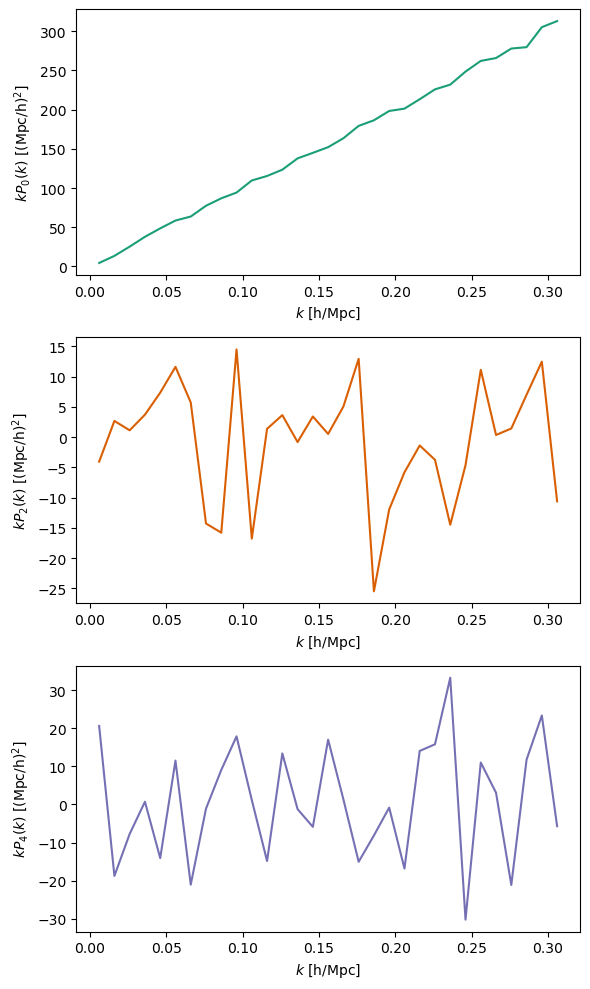

In [52]:
# Get and vectorize relevant functionals
cmap = plt.get_cmap('Dark2')
plt.figure(figsize=(6,10))
for i_ell, ell in enumerate(config['multipoles']):
    plt.subplot(3,1,i_ell+1)
    plt.plot(pk[0].T, (pk[0]*pk[i_ell+1]).T, color=cmap(i_ell))
    plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P_{ell}(k)$ [(Mpc/h)$^2$]")
plt.tight_layout()